### **Reducing the winding number of a cocycle** 

In [1]:
using Pkg
Pkg.activate("../.")
Pkg.instantiate()

  Activating project at `~/Documents/student/10_semester/thesis_paper/lifting-heuristic-circular-coordinates`


In [2]:
using LinearAlgebra
using Plots
using Ripserer
using CSV
using Distances
using AbstractAlgebra
using AbstractAlgebra
using Oscar
using SparseArrays
using StatsBase
using Random
using IterativeSolvers
using MultivariateStats
using LinearAlgebra
using CairoMakie

In [3]:
include("../src/circular-coordinates.jl")
include("../src/datasets.jl")
using .CircularCoordinates
using .Datasets

In [4]:
"""
Our field of choice to compute persitence cohomology
"""

ph_field = 47

47

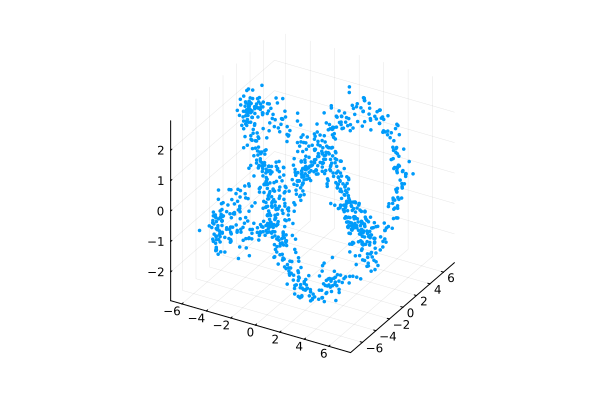

In [5]:
data, θ = Datasets.torus_knot(p=2, q=3, n_samples=1000, R=5.0, r=2.0, noise_var=0.1, type_noise="gaussian")

distance_matrix = pairwise(Euclidean(), data');

scatter3d(
    data[:, 1],
    data[:, 2],
    data[:, 3],
    markersize=2,         # Adjust the size of the points
    markerstrokewidth=0,  # Removes the border from points for a cleaner look
    legend=false          # No need for a legend with only one data series
)


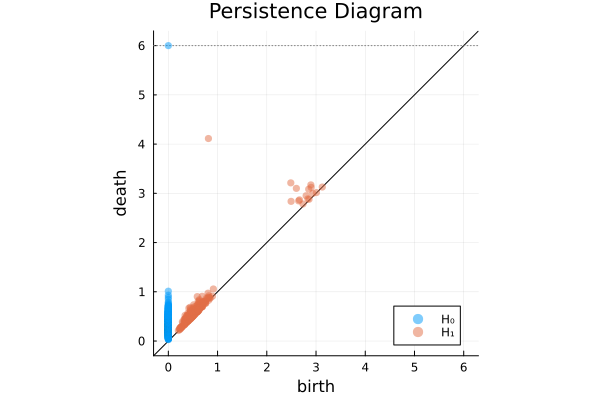

In [6]:
threshold_ = 6.0


"""

Compute Persistence cohomology

"""

rips = Ripserer.Rips(distance_matrix, sparse=false, threshold=threshold_)

diagram_cocycles = ripserer(rips; reps=[1], field=Ripserer.Mod{ph_field})
thresh_for_X = 2.0 # Pick a low threshold

Plots.plot(diagram_cocycles)



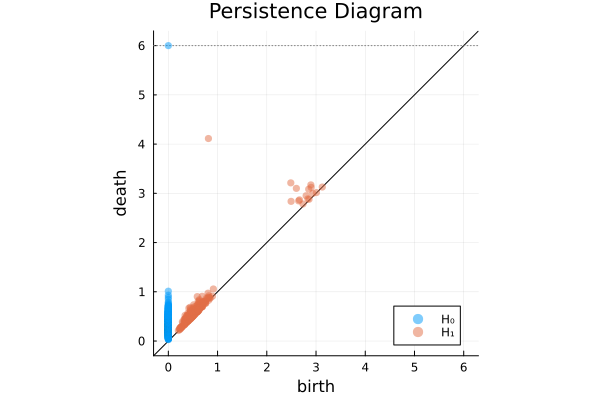

In [7]:
"""

Compute Persistence homology

"""


rips_ho = Ripserer.Rips(distance_matrix, sparse=false, threshold=threshold_)

diagram_cycles = ripserer(rips_ho; alg=:involuted, field=Ripserer.Mod{ph_field}, reps=[1])
Plots.plot(diagram_cycles)


In [8]:

"""
We look at the same point for homology/cohomology, the most persistence feature
"""

LOOK_AT_COCYCLE = 0
LOOK_AT_CYCLE = 0;

In [9]:
most_persistent_co = diagram_cocycles[2][end-LOOK_AT_COCYCLE]
cocycle = Ripserer.representative(most_persistent_co);
simps_co = Ripserer.vertices.(cocycle);
simps_co = simps_co[Ripserer.birth.(cocycle).<thresh_for_X]
cocycle = cocycle[Ripserer.birth.(cocycle).<thresh_for_X];

In [10]:
most_persistent_ho = diagram_cycles[2][end-LOOK_AT_CYCLE]
cycle = Ripserer.representative(most_persistent_ho);
simps_ho = Ripserer.vertices.(cycle);

In [11]:
"""
In order to successfully lift the cycle to an integer cycle, we need to scale it by 2.
The cocycle already has coefficients in the proper range
"""

SCALE_COCYCLE = 1
SCALE_CYCLE = 2

2

In [12]:
coeff_co = Ripserer.coefficient.(cocycle);
coeff_co = coeff_co * SCALE_COCYCLE

α = Int.(coeff_co);
α[α.>=ph_field÷2] .-= ph_field;
α = Int.(α * 1);
countmap(Int.(α))

Dict{Int64, Int64} with 2 entries:
  2  => 113
  -2 => 26

In [13]:
coeff_ho = coefficient.(cycle)
coeff_ho = coeff_ho * SCALE_CYCLE;
countmap(Int.(coeff_ho))

Dict{Int64, Int64} with 5 entries:
  4  => 1
  2  => 26
  45 => 18
  46 => 118
  1  => 118

In [14]:
"""
If this prints something, we cant lift the cycle. If its quite, then its no problem
"""

CircularCoordinates.verify_coefficients_indexed(simps_ho, Int.(coeff_ho), ph_field)

In [15]:
β = Int.(coeff_ho);
β[β.>=ph_field÷2] .-= ph_field;
β = 1 * β;

In [16]:
"""

Compute the Kronecker pairing to deduce the winding number of the cocycle

"""

res = 0
for i in 1:length(coeff_co)
    index = findfirst(isequal(simps_co[i]), simps_ho)
    if index !== nothing
        print("Index: ", index, ", Values: COHO ", α[i], " * HO ", β[index])
        res += α[i] * β[index]
    end
end
res # This returns 2 either the cycle or cocycle has winding number ±2.

Index: 1, Values: COHO 2 * HO 1

2

In [31]:
"""
We lift the cocycle we found and compute the circular coordinates
"""

edges_X = Ripserer.vertices.(Ripserer.edges(rips))[birth.(Ripserer.edges(rips)).<thresh_for_X]
D_tilde, simps_tilde, L1_dim = CircularCoordinates.build_complex_and_boundary_operator(Ripserer.vertices(rips), edges_X);
multpl = 1
cocycle = cocycle[birth.(cocycle).<thresh_for_X]
base_change_cocycle_tilde = CircularCoordinates.base_change(D_tilde, cocycle, ph_field, multpl);
countmap(base_change_cocycle_tilde)

θ_2 = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde[1:size(data)[1], 1:L1_dim]), base_change_cocycle_tilde[1:L1_dim])), 1.0);

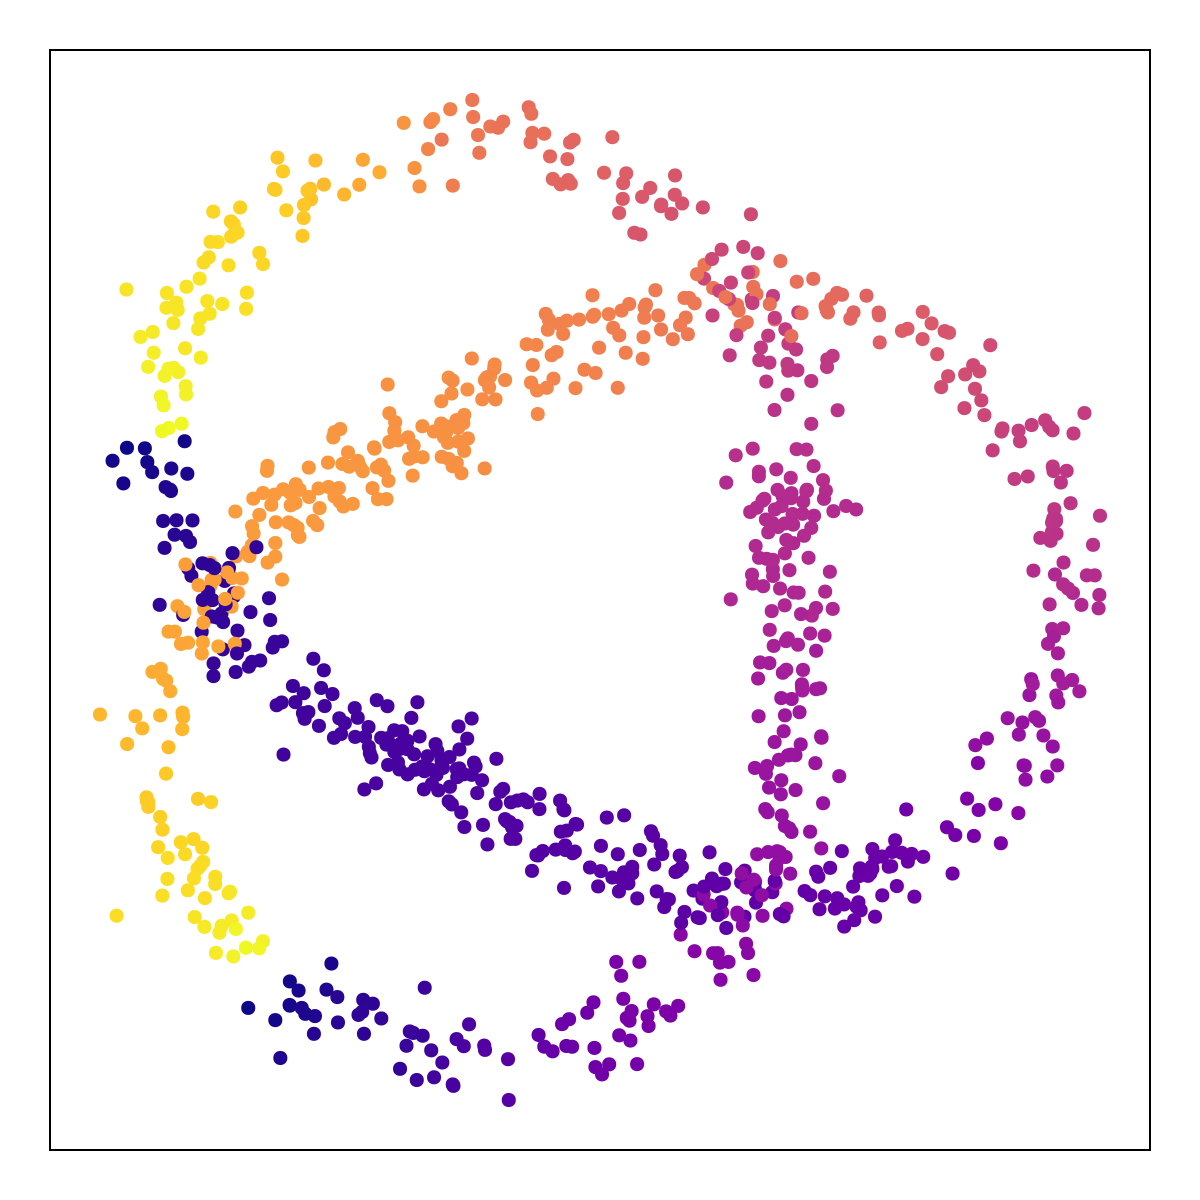

CairoMakie.Screen{PDF}


In [32]:
fig_2 = Figure(size=(600, 600), fontsize=14, figure_padding=25)
ax_2d = Axis(fig_2[1, 1]; aspect=1)
CairoMakie.scatter!(ax_2d, data[:, 1], data[:, 2];
    markersize=10,
    color=θ_2,
    colormap=:plasma,
    transparency=true
)
hidexdecorations!(ax_2d; ticks=true, ticklabels=true, grid=true)
hideydecorations!(ax_2d; ticks=true, ticklabels=true, grid=true)
display(fig_2)

CairoMakie.save("../figs/algorithm_1_example_winding_2.pdf", fig_2)

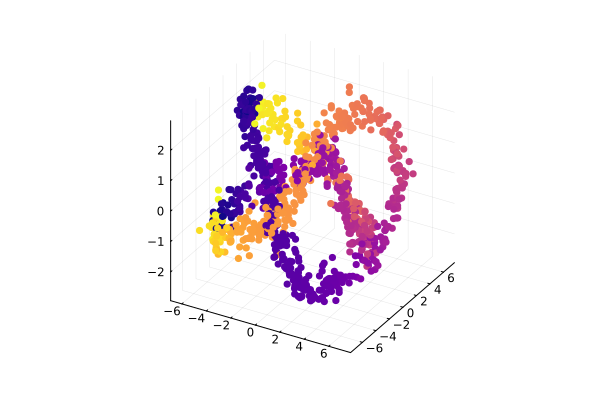

In [20]:
"""
We also include a 3D plot of the trefoil with the circular coordinates.
"""

Plots.scatter(data[:, 1], data[:, 2], data[:, 3],
    zcolor=θ,
    color=:plasma,
    legend=false,
    markerstrokewidth=0,
    markersize=4
)

In [21]:
"""
We need to check if the cocycle as winding number 2
"""

field_to_check = 2
F = AbstractAlgebra.GF(field_to_check)

Finite field F_2

In [22]:

"""
The cocycle has winding number zero if it is a boundary mod 2. This is trivially true in this case as the 
GCD of the coordinates of the cocycle is 2. 
However, we do the algorithm the a general.
"""

D_tilde_mod_F = sparse_matrix(F, Array(D_tilde[1:L1_dim, 1:L1_dim]))

base_change_cocycle_tilde_2_mod_F = sparse_matrix(F, Array(reshape(deepcopy(base_change_cocycle_tilde[1:L1_dim]), :, 1)))

"""

IF this fails to find a solution, i.e., returns False, it means that base_change_cocycle_tilde_2_mod_F is not a boundary mod field_to_check.

IF this returns true then the winding number divides 2

"""

# cocycle_a_boundary_questionmark = Oscar.can_solve(transpose(D_tilde_mod_F), base_change_cocycle_tilde_2_mod_F)


"\nIF this fails to find a solution, i.e., returns False, it means that base_change_cocycle_tilde_2_mod_F is not a boundary mod field_to_check.\n\nIF this returns true then the winding number divides 2\n\n"

In [23]:
order_of_alpha = 2

2

In [24]:
"""
We choose some field to do the calculations as in Proposition 4.4 and proceed with a step in Algorithm 1.
We only need one step.
"""

big_field = 47
big_F = AbstractAlgebra.GF(big_field)
slice = base_change_cocycle_tilde[length(data)+1:L1_dim]
reshaped_slice = Array(reshape(base_change_cocycle_tilde[length(data)+1:L1_dim], length(slice), 1))
α_1 = sparse_matrix(big_F, reshaped_slice)
D_0 = sparse_matrix(big_F, Array(transpose(D_tilde)[1:L1_dim-length(data), 1:L1_dim]))
D_tilde_mod_F = sparse_matrix(big_F, Array(D_tilde[1:L1_dim, 1:L1_dim]))
identity_matri_times_order = Oscar.sparse_matrix(identity_matrix(big_F, L1_dim - length(data))) * order_of_alpha
A = hcat(identity_matri_times_order, D_0)
γ = Array(Oscar.solve(A, α_1))[:, 1];

In [25]:
"""
In order to proceed we need that these values are liftable, i.e., in {-p/3, ... ,-1, 0, 1, ..., p/3}
"""

countmap(AbstractAlgebra.lift.(γ)) #it is ok

Dict{BigInt, Int64} with 3 entries:
  0  => 25184
  46 => 26
  1  => 105

In [27]:
"""
We compute the circular coordinates of γ
"""

new_gamma = Int.([zeros(length(data)); AbstractAlgebra.lift.(Array(γ)[:, 1]); zeros(size(D_tilde, 1) - L1_dim)])
unique(new_gamma)
new_gamma[new_gamma.>=big_field÷2] .-= big_field
new_gamma = 1 * new_gamma

θ_1 = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde), new_gamma)[1:size(data, 1)]), 1.0);

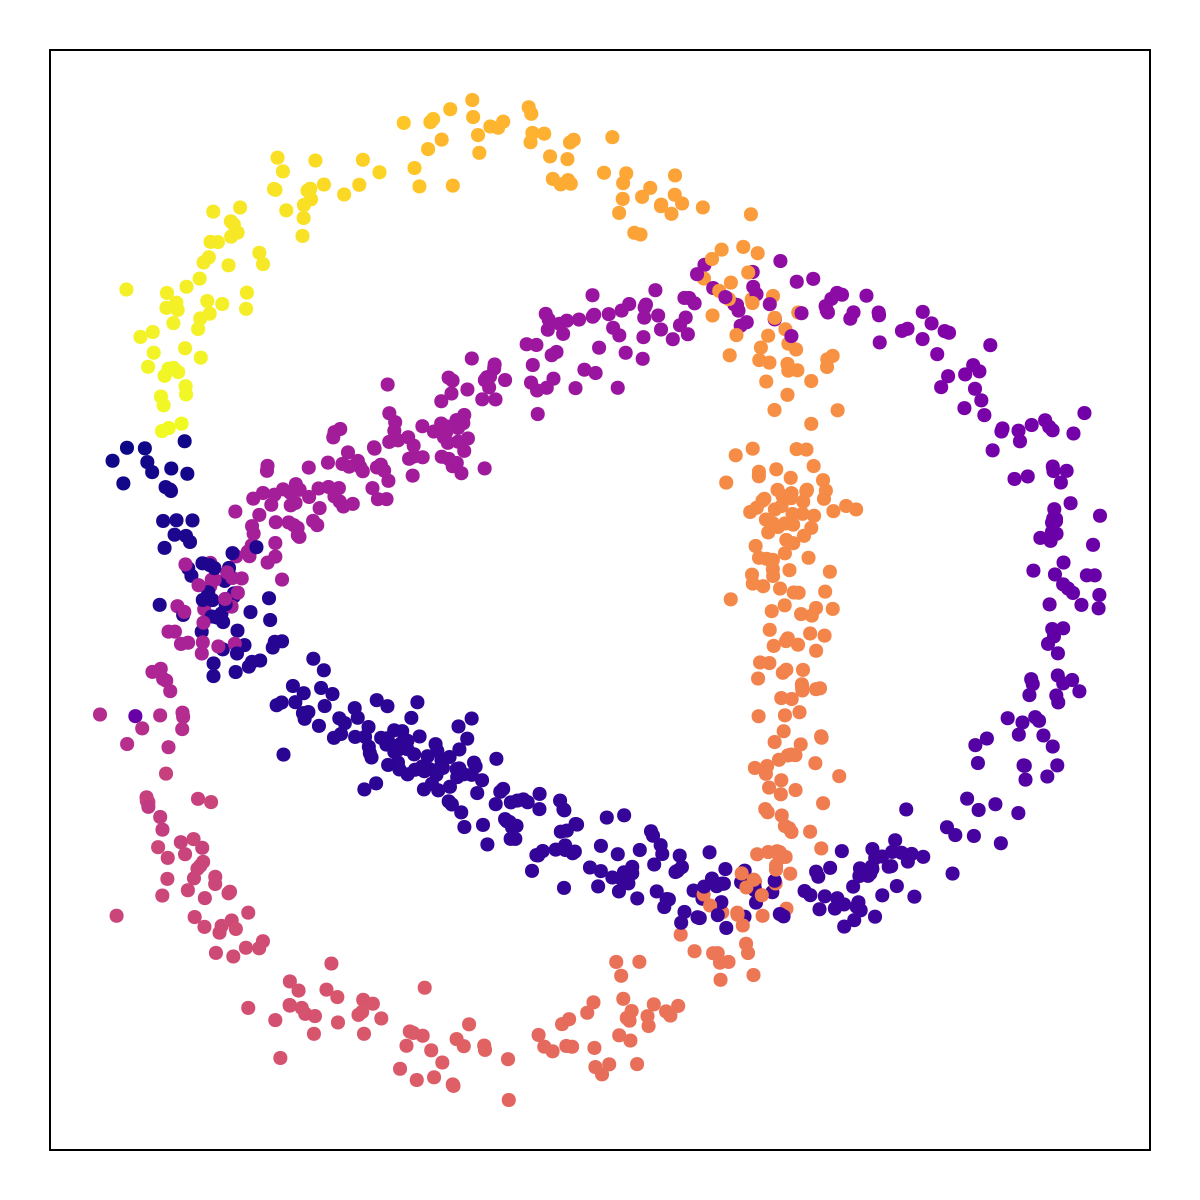

CairoMakie.Screen{PDF}


In [29]:
fig_1 = Figure(size=(600, 600), fontsize=14, figure_padding=25)
ax_2d = Axis(fig_1[1, 1]; aspect=1)
CairoMakie.scatter!(ax_2d, data[:, 1], data[:, 2];
    markersize=10,
    color=θ_1,
    colormap=:plasma,
    transparency=true
)
hidexdecorations!(ax_2d; ticks=true, ticklabels=true, grid=true)
hideydecorations!(ax_2d; ticks=true, ticklabels=true, grid=true)
display(fig_1)


CairoMakie.save("../figs/algorithm_1_example_winding_1.pdf", fig_1)


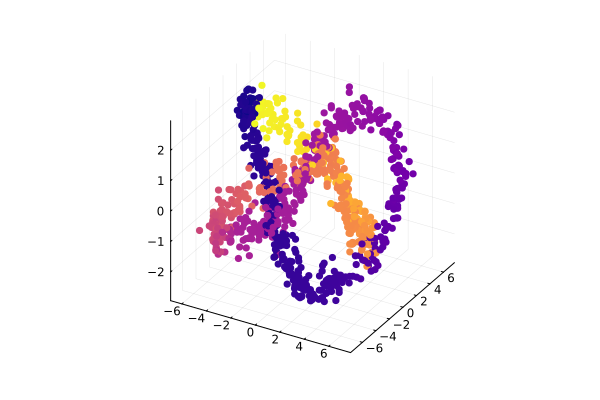

In [26]:
"""
We also include a 3D plot of the trefoil with the circular coordinates.
"""


Plots.scatter(data[:, 1], data[:, 2], data[:, 3],
    zcolor=θ,
    color=:plasma,
    legend=false,
    markerstrokewidth=0,
    markersize=4
)

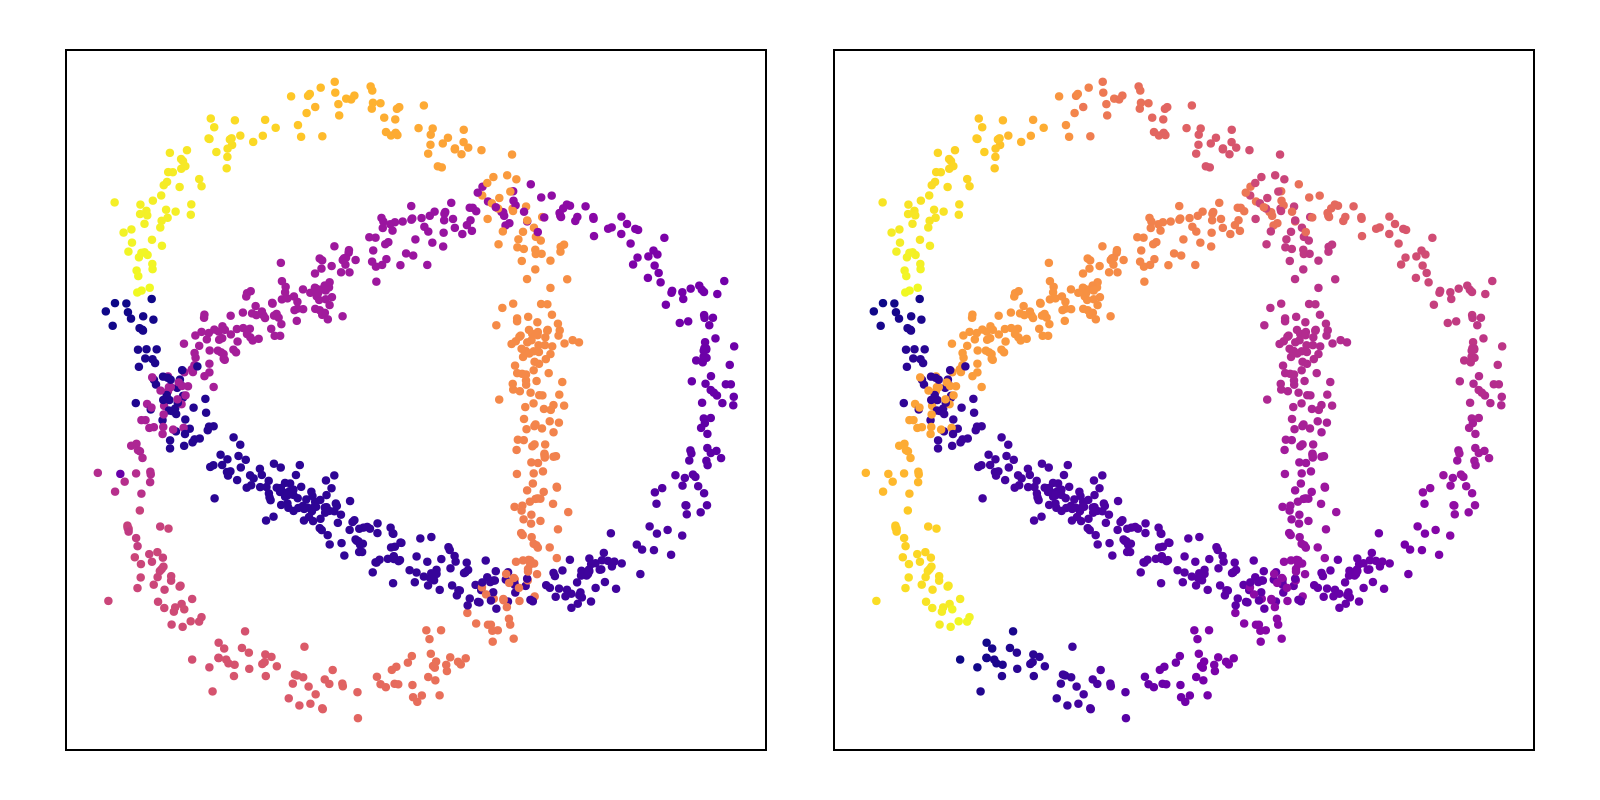

CairoMakie.Screen{PDF}


In [36]:
θ_cc_array = [θ_1, θ_2]

fig = Figure(size=(800, 400), fontsize=14, figure_padding=25)
for (i, θs) in enumerate(θ_cc_array)
    ax = Axis(fig[1, i]; aspect=1)
    CairoMakie.scatter!(ax, data[:, 1], data[:, 2];
        markersize=6,
        color=θs,
        colormap=:plasma,
        transparency=true
    )
    hidexdecorations!(ax; ticks=true, ticklabels=true, grid=true)
    hideydecorations!(ax; ticks=true, ticklabels=true, grid=true)
end
display(fig)

CairoMakie.save("../figs/algorithm_1_example_trefoil.pdf", fig)